In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import scipy.misc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from keras.models import Sequential
import keras.optimizers as opt
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.layers import Input

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import RandomUniform, GlorotUniform, Constant, Identity

In [ ]:
! unzip /content/drive/MyDrive/archive.zip

In [5]:
import cv2

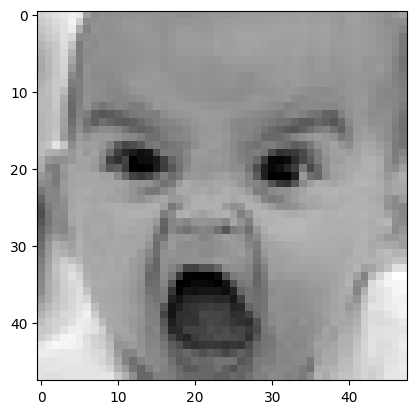

In [6]:
img_array=cv2.imread("/content/train/angry/Training_233976.jpg")
plt.imshow(img_array)

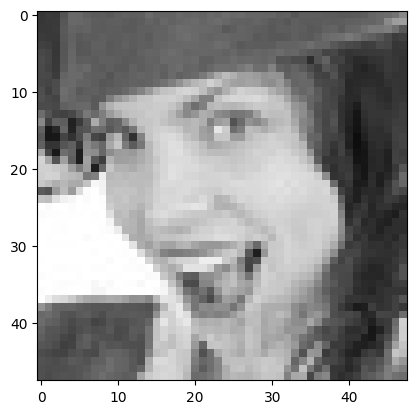

In [7]:
img_array=cv2.imread("/content/train/happy/Training_10288829.jpg")
plt.imshow(img_array)

In [8]:
import os
from PIL import Image
train_dir= "/content/train"
test_dir= "/content/test"

In [9]:
def load_images_and_labels_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                img = Image.open(os.path.join(label_path, filename))
                if img is not None:
                    images.append(img)
                    labels.append(label)
    return images, labels
train_images, train_labels = load_images_and_labels_from_folder(train_dir)
test_images, test_labels= load_images_and_labels_from_folder(test_dir)

In [10]:
print(len(train_images))
print(len(test_images))

28709
7178


In [11]:
new_size = (48, 48)

train_images = [img.resize(new_size) for img in train_images]
test_images = [img.resize(new_size) for img in test_images]
train_data = np.array([np.array(img) for img in train_images])
test_data = np.array([np.array(img) for img in test_images])

In [12]:
print(train_data.shape)

(28709, 48, 48)


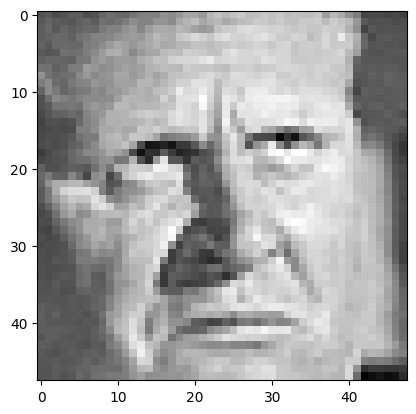

In [13]:
# plt.imshow(np.array(train_images[23304], dtype = 'uint8').reshape(48,48,1), cmap = 'gray')
plt.imshow(train_data[23304], cmap = 'gray')

In [14]:
print(train_labels[23304])

angry


In [15]:
# Converting to float32 for normalization
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

In [16]:
train_data = train_data / 255.0
test_data = test_data / 255.0

In [17]:
# Define a mapping dictionary for label conversion
label_to_index = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprise": 6
}
# Convert the text labels to numerical labels
train_labels= [label_to_index[label] for label in train_labels]
test_labels = [label_to_index[label] for label in test_labels]

In [18]:
# Shuffle the indices of the dataset
num_train_samples = len(train_data)
num_test_samples = len(test_data)

train_indices = np.arange(num_train_samples)
test_indices = np.arange(num_test_samples)

np.random.shuffle(train_indices)
np.random.shuffle(test_indices)

# Use the shuffled indices to shuffle the data and labels
shuffled_train_data = train_data[train_indices]
shuffled_train_labels = np.array(train_labels)[train_indices]

shuffled_test_data = test_data[test_indices]
shuffled_test_labels = np.array(test_labels)[test_indices]


In [19]:
# Reshaping data and convert labels to one-hot encoding
X_train = shuffled_train_data.reshape(shuffled_train_data.shape[0], 48, 48, 1)
X_test = shuffled_test_data.reshape(shuffled_test_data.shape[0], 48, 48, 1)

y_train_one_hot = tf.one_hot(shuffled_train_labels, depth=7)
y_test_one_hot = tf.one_hot(shuffled_test_labels, depth=7)

In [ ]:
#SPARE
X_train = np.array(shuffled_train_data, dtype = 'uint8')
y_train = np.array(shuffled_train_labels, dtype = 'uint8')
X_test = np.array(shuffled_test_data, dtype = 'uint8')
y_test = np.array(shuffled_test_labels, dtype = 'uint8')

In [ ]:
#SPARE
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [ ]:
#SPARE
y_train_one_hot = tf.one_hot(y_train, depth=7)
y_test_one_hot = tf.one_hot(y_test, depth=7)

In [21]:
datagen = ImageDataGenerator(
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator()
datagen.fit(X_train)
batch_size = 64

In [22]:
train_flow = datagen.flow(X_train, y_train_one_hot, batch_size=batch_size)
test_flow = testgen.flow(X_test, y_test_one_hot, batch_size=batch_size)

In [23]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.layers import ZeroPadding2D
from keras.layers import Activation
from keras.layers import Add
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor

Resnet 18 architecture

In [ ]:
def identity_block18(X, filters, initializer=random_uniform):
    # Retrieve Filters
    F1, F2 = filters
    # Save the input value. We will need this later to add back to the main path.
    X_shortcut = X
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)

    X = Conv2D(filters=F2,kernel_size=3,strides=(1,1),padding="same",kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block18(X, filters, initializer=glorot_uniform,s=2):
    F1, F2 = filters

    # Save the input value
    X_shortcut = X

    X = Conv2D(filters = F1, kernel_size = 1, strides = s, padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2,kernel_size=(3,3),strides=(1,1),padding='same',kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation("relu")(X)

    X_shortcut = Conv2D(filters=F2,kernel_size=1,strides=s,padding='valid',kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut =  BatchNormalization(axis=3)(X_shortcut)

    # Final step: Adding shortcut value to main path,and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet18(input_shape = (48,48,1), classes = 7, training=False):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block18(X, filters = [64, 64],s=1)
    X = identity_block18(X, filters = [64, 64])

    X = convolutional_block18(X, filters =  [128,128])
    X = identity_block18(X, filters =  [128,128])

    # the 3 `identity_block`
    # add `convolutional_block`
    X = convolutional_block18(X, filters = [256, 256])
    X = identity_block18(X, filters = [256, 256])

   # add `convolutional_block`
    X = convolutional_block18(X, filters =[512, 512])
    X = identity_block18(X, filters =[512, 512])

    X = AveragePooling2D((2,2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model


In [ ]:
model18 = ResNet18(input_shape=(48, 48, 1), classes=7)
opt = tf.keras.optimizers.Adam(learning_rate=0.00015)
model18.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Resnet 18 accuracy

In [ ]:
model18.fit(train_flow, epochs=50, validation_data=test_flow)

Epoch 1/50
449/449 [==============================] - 37s 47ms/step - loss: 1.7515 - accuracy: 0.3013 - val_loss: 1.8332 - val_accuracy: 0.2561
Epoch 2/50
449/449 [==============================] - 18s 40ms/step - loss: 1.5970 - accuracy: 0.3750 - val_loss: 1.5384 - val_accuracy: 0.4061
Epoch 3/50
449/449 [==============================] - 20s 44ms/step - loss: 1.5046 - accuracy: 0.4146 - val_loss: 1.5096 - val_accuracy: 0.4200
Epoch 4/50
449/449 [==============================] - 20s 44ms/step - loss: 1.4268 - accuracy: 0.4490 - val_loss: 1.3997 - val_accuracy: 0.4539
Epoch 5/50
449/449 [==============================] - 18s 40ms/step - loss: 1.3692 - accuracy: 0.4735 - val_loss: 1.4320 - val_accuracy: 0.4540
Epoch 6/50
449/449 [==============================] - 18s 40ms/step - loss: 1.3278 - accuracy: 0.4886 - val_loss: 1.3388 - val_accuracy: 0.4790
Epoch 7/50
449/449 [==============================] - 19s 43ms/step - loss: 1.2815 - accuracy: 0.5116 - val_loss: 1.2987 - val_accuracy:

In [ ]:
model18.fit(train_flow, epochs=50, validation_data=test_flow)

Epoch 1/50
449/449 [==============================] - 19s 43ms/step - loss: 0.6979 - accuracy: 0.7415 - val_loss: 1.2608 - val_accuracy: 0.5818
Epoch 2/50
449/449 [==============================] - 18s 41ms/step - loss: 0.6914 - accuracy: 0.7438 - val_loss: 1.2780 - val_accuracy: 0.5655
Epoch 3/50
449/449 [==============================] - 19s 42ms/step - loss: 0.6777 - accuracy: 0.7485 - val_loss: 1.2363 - val_accuracy: 0.5823
Epoch 4/50
449/449 [==============================] - 18s 39ms/step - loss: 0.6722 - accuracy: 0.7493 - val_loss: 1.2415 - val_accuracy: 0.5871
Epoch 5/50
449/449 [==============================] - 19s 42ms/step - loss: 0.6605 - accuracy: 0.7550 - val_loss: 1.2228 - val_accuracy: 0.5947
Epoch 6/50
449/449 [==============================] - 18s 39ms/step - loss: 0.6495 - accuracy: 0.7594 - val_loss: 1.2730 - val_accuracy: 0.5807
Epoch 7/50
449/449 [==============================] - 19s 42ms/step - loss: 0.6422 - accuracy: 0.7635 - val_loss: 1.2307 - val_accuracy:

In [ ]:
model18.evaluate(X_test,y_test_one_hot)

225/225 [==============================] - 1s 6ms/step - loss: 1.4648 - accuracy: 0.6232


[1.4648303985595703, 0.6231541037559509]

In [ ]:
model18.save('/content/drive/MyDrive/emotiondetection_resnet18.keras')

Resnet 50 architecture

In [24]:
def identity_block50(X, f, filters, initializer=random_uniform):
    """Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    # Retrieve Filters
    F1, F2, F3 = filters
    # Save the input value. We will need this later to add back to the main path.
    X_shortcut = X
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)
    ## Set the padding = 'same'
    X = Conv2D(filters=F2,kernel_size=f,strides=(1,1),padding="same",kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
   ## Set the padding = 'valid'
    X = Conv2D(filters=F3,kernel_size=1,strides=1,padding='valid',kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    ## Final step: Adding shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    return X

In [25]:
def convolutional_block50(X, f, filters, s = 2, initializer=glorot_uniform):
    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path glorot_uniform
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s,s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Second component of main path
    X = Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation("relu")(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X =  BatchNormalization(axis=3)(X)

    ##### SHORTCUT PATH #####
    X_shortcut = Conv2D(filters=F3,kernel_size=1,strides=(s,s),padding='valid',kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut =  BatchNormalization(axis=3)(X_shortcut)

    # Final step: Adding shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [26]:
def ResNet50(input_shape = (48,48,1), classes = 7, training=False):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block50(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block50(X, 3, [64, 64, 256])
    X = identity_block50(X, 3, [64, 64, 256])
    X = convolutional_block50(X, f = 3, filters =  [128,128,512], s = 2)
    # the 3 `identity_block`
    X =  identity_block50(X, 3,  [128,128,512] )
    X =  identity_block50(X, 3,  [128,128,512] )
    X =  identity_block50(X, 3,  [128,128,512] )
    X = convolutional_block50(X, f = 3, filters = [256, 256, 1024], s = 2)
    # the 5 `identity_block`
    X = identity_block50(X, 3, [256, 256, 1024])
    X = identity_block50(X, 3, [256, 256, 1024])
    X = identity_block50(X, 3, [256, 256, 1024])
    X = identity_block50(X, 3, [256, 256, 1024])
    X = identity_block50(X, 3, [256, 256, 1024])
    X = convolutional_block50(X, f = 3, filters =[512, 512, 2048], s = 2)
    # the 2 `identity_block`
    X =identity_block50(X, 3,[512, 512, 2048])
    X = identity_block50(X, 3,[512, 512, 2048])
    X = AveragePooling2D((2,2))(X)
    # output layer
    X = Flatten()(X)
    X = Dense(7, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    # Create model
    model = Model(inputs = X_input, outputs = X)
    return model

In [27]:
tf.keras.backend.set_learning_phase(True)

model50 = ResNet50(input_shape = (48,48,1), classes = 7)
opt = tf.keras.optimizers.Adam(learning_rate=0.00015)
model50.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Resnet 50 accuracy

In [28]:
model50.fit(train_flow, epochs=100, validation_data=test_flow)

Epoch 1/100
449/449 [==============================] - 81s 87ms/step - loss: 1.9909 - accuracy: 0.2514 - val_loss: 1.8379 - val_accuracy: 0.2053
Epoch 2/100
449/449 [==============================] - 38s 84ms/step - loss: 1.7781 - accuracy: 0.3256 - val_loss: 1.9755 - val_accuracy: 0.3649
Epoch 3/100
449/449 [==============================] - 35s 78ms/step - loss: 1.6700 - accuracy: 0.3680 - val_loss: 3.4138 - val_accuracy: 0.3045
Epoch 4/100
449/449 [==============================] - 35s 77ms/step - loss: 1.5994 - accuracy: 0.3977 - val_loss: 1.8065 - val_accuracy: 0.3363
Epoch 5/100
449/449 [==============================] - 37s 82ms/step - loss: 1.5135 - accuracy: 0.4174 - val_loss: 2.2138 - val_accuracy: 0.2609
Epoch 6/100
449/449 [==============================] - 35s 78ms/step - loss: 1.4465 - accuracy: 0.4486 - val_loss: 1.3757 - val_accuracy: 0.4656
Epoch 7/100
449/449 [==============================] - 34s 77ms/step - loss: 1.4425 - accuracy: 0.4504 - val_loss: 1.4345 - val_ac

KeyboardInterrupt: 

In [29]:
model50.evaluate(X_test,y_test_one_hot)

225/225 [==============================] - 4s 13ms/step - loss: 1.3193 - accuracy: 0.6273


[1.3192954063415527, 0.6273335218429565]

In [30]:
model50.save('/content/drive/MyDrive/emotiondetection_resnet50.keras')

In [52]:
model_path18 = '/content/drive/MyDrive/emotiondetection_resnet18.keras'
model18 = tf.keras.models.load_model(model_path18)

In [43]:
import cv2
import numpy as np
import tensorflow as tf

model_path = '/content/drive/MyDrive/emotiondetection_resnet50.keras'
model = tf.keras.models.load_model(model_path)

In [44]:
# Function to preprocess image for model input
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Resize to 48x48
    resized = cv2.resize(gray, (48, 48))
    # Normalize pixel values
    processed_image = resized / 255.0
    # Reshape for model input (add batch dimension)
    processed_image = np.expand_dims(processed_image, axis=0)
    processed_image = np.expand_dims(processed_image, axis=-1)
    return processed_image

# Function to detect faces using Haar cascade
def detect_faces(image):
    # Load the Haar cascade for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.3, minNeighbors=5)
    return faces

# Function to classify emotion using the loaded model
def classify_emotion(face_image):
    # Preprocess the face image
    processed_face = preprocess_image(face_image)
    # Predict emotion using the model
    predictions = model.predict(processed_face)
    # Get the predicted emotion label
    emotion_index = np.argmax(predictions)
    emotion_label = labels[emotion_index]

    return emotion_label

In [45]:
from google.colab.patches import cv2_imshow

labels = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

# Function to process and display the image
def predict_image(image_path):
    # Loading the input image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read the image from file: {image_path}")
        return
    # Detecting faces in the image
    faces = detect_faces(image)
    # Iterating over detected faces
    for (x, y, w, h) in faces:
        # Extract the face region
        face_image = image[y:y+h, x:x+w]
        # Classify emotion
        emotion_label = classify_emotion(face_image)
        # Draw bounding box around the face
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
        # Display emotion label above the bounding box
        text = f"{emotion_label}"
        cv2.putText(image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    # Display the image with bounding boxes and emotion labels
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 22ms/step


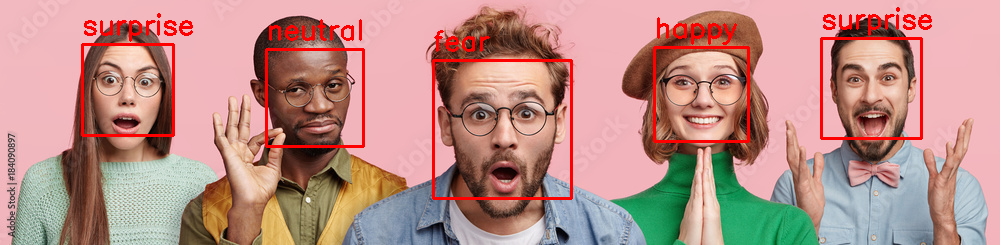

In [46]:
image_path = "/content/mixed.jpg"
predict_image(image_path)

1/1 [==============================] - 0s 36ms/step


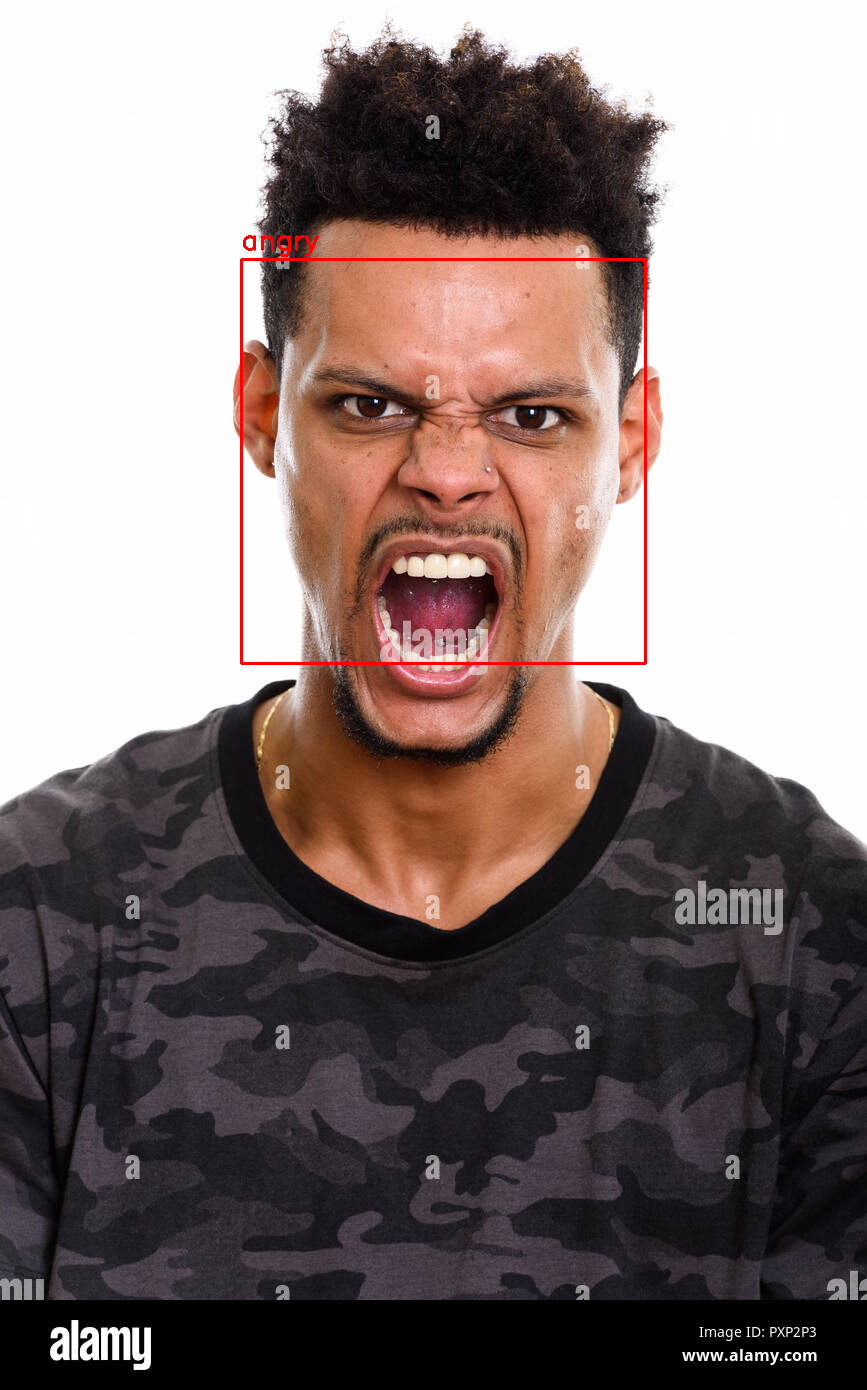

In [47]:
image_path = "/content/angrytest.jpg"
predict_image(image_path)

1/1 [==============================] - 0s 17ms/step


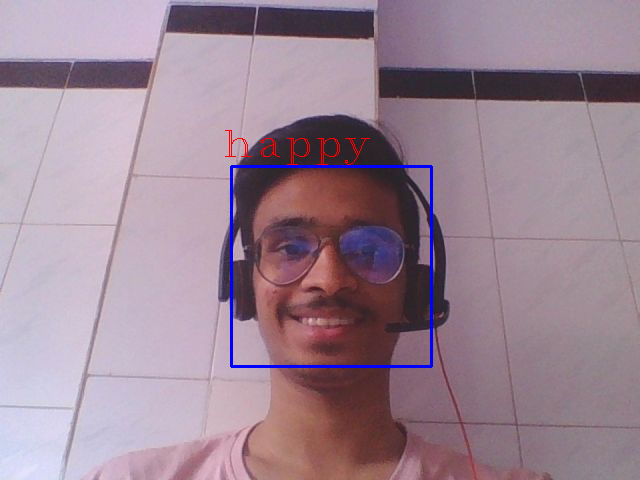

In [ ]:
image_path = "/content/mohammedtest.jpeg"
predict_image(image_path)